In [2]:
! /opt/bin/nvidia-smi

Sun May  9 14:13:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# run this cell, then restart the runtime before continuing
!pip install git+https://github.com/huggingface/transformers.git
!pip install nlp

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-qcig8fe7
  Running command git clone -q https://github.com/huggingface/transformers.git /tmp/pip-req-build-qcig8fe7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.3MB 12.8MB/s 
     |████████████████████████████████| 901kB 43.7MB/s 
  Created wheel for transformers: filename=transformers-4.6.0.dev0-cp37-none-any.whl size=2213074 sha256=1ff3f4b12bba0f4edd8cb13b1f772262ce2ddda46e727938b4067c54d2560a9a
  Stored in directory: /tmp/pip-ephem-wheel-cache-4waodsrl/wheels/33/eb/3b/4bf5dd835e865e472d4fc0754f35ac0edb08fe852e8f21655f
Successfully built transformers
     |████████████████████████████████| 1.7MB 12.7MB/s 
     |████████████████████████████████| 245kB 50.3MB/s 


In [4]:
from transformers import BertForSequenceClassification, BertTokenizerFast, Trainer, TrainingArguments, ReformerConfig, TrainerCallback
from nlp import load_dataset
import torch
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
train_dataset, test_dataset = load_dataset('imdb', split=['train', 'test'])
train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/76cdbd7249ea3548c928bbf304258dab44d09cd3638d9da8d42480d1d1be3743. Subsequent calls will reuse this data.


In [6]:
torch.cuda.empty_cache()
full_attention_config = ReformerConfig.from_pretrained("bert-base-uncased", lsh_attn_chunk_length=512, local_attn_chunk_length=512, attn_layers=["lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh"])
full_attention_model = BertForSequenceClassification(full_attention_config)

full_attention_steps = []
full_attention_loss = []

class FullAttentionLossCallback(TrainerCallback):
    def on_train_end(self, args, state, control, **kwargs):
      log_history = state.log_history
      for index in range(len(log_history) - 1):
        log = log_history[index]
        full_attention_steps.append(log['step'])
        full_attention_loss.append(log['loss'])

full_attention_training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=8,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    # evaluation_strategy="steps",
    # eval_steps=200,
    logging_steps=100,
    # evaluate_during_training=True,
    logging_dir='./logs',
)

full_attention_model_trainer = Trainer(
    model=full_attention_model,
    args=full_attention_training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

full_attention_model_trainer.add_callback(FullAttentionLossCallback())
full_attention_model_trainer.train()

You are using a model of type bert to instantiate a model of type reformer. This is not supported for all configurations of models and can yield errors.


Step,Training Loss
100,0.702800
200,0.715200
300,0.695300
400,0.682500
500,0.599700
600,0.537600
700,0.492700
800,0.462000
900,0.452700
1000,0.399100


TrainOutput(global_step=12504, training_loss=0.1817572454034672, metrics={'train_runtime': 3971.9637, 'train_samples_per_second': 3.148, 'total_flos': 11518668521472.0, 'epoch': 8.0, 'init_mem_cpu_alloc_delta': 1320120320, 'init_mem_gpu_alloc_delta': 268963328, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 194383872, 'train_mem_gpu_alloc_delta': 806692352, 'train_mem_cpu_peaked_delta': 153743360, 'train_mem_gpu_peaked_delta': 6720325120})

In [7]:
torch.cuda.empty_cache()
lsh_1_config = ReformerConfig.from_pretrained("bert-base-uncased", num_hash=1, attn_layers=["lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh"])
lsh_1_model = BertForSequenceClassification(lsh_1_config)

lsh_1_steps = []
lsh_1_loss = []

class LSH_1_LossCallback(TrainerCallback):
    def on_train_end(self, args, state, control, **kwargs):
      log_history = state.log_history
      for index in range(len(log_history) - 1):
        log = log_history[index]
        lsh_1_steps.append(log['step'])
        lsh_1_loss.append(log['loss'])

lsh_1_training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=8,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    # evaluation_strategy="steps",
    # eval_steps=200,
    logging_steps=100,
    # evaluate_during_training=True,
    logging_dir='./logs',
)

lsh_1_trainer = Trainer(
    model=lsh_1_model,
    args=lsh_1_training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

lsh_1_trainer.add_callback(LSH_1_LossCallback())
lsh_1_trainer.train()

You are using a model of type bert to instantiate a model of type reformer. This is not supported for all configurations of models and can yield errors.


Step,Training Loss
100,0.701900
200,0.716500
300,0.700600
400,0.718400
500,0.603900
600,0.464600
700,0.459400
800,0.405200
900,0.421800
1000,0.391500


TrainOutput(global_step=12504, training_loss=0.18050884308742737, metrics={'train_runtime': 3993.2187, 'train_samples_per_second': 3.131, 'total_flos': 11518668521472.0, 'epoch': 8.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 268439040, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -133427200, 'train_mem_gpu_alloc_delta': 808265216, 'train_mem_cpu_peaked_delta': 133857280, 'train_mem_gpu_peaked_delta': 6603982336})

In [8]:
torch.cuda.empty_cache()
lsh_2_config = ReformerConfig.from_pretrained("bert-base-uncased", num_hash=2, attn_layers=["lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh"])
lsh_2_model = BertForSequenceClassification(lsh_2_config)

lsh_2_steps = []
lsh_2_loss = []

class LSH_2_LossCallback(TrainerCallback):
    def on_train_end(self, args, state, control, **kwargs):
      log_history = state.log_history
      for index in range(len(log_history) - 1):
        log = log_history[index]
        lsh_2_steps.append(log['step'])
        lsh_2_loss.append(log['loss'])

lsh_2_training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=8,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    # evaluation_strategy="steps",
    # eval_steps=200,
    logging_steps=100,
    # evaluate_during_training=True,
    logging_dir='./logs',
)

lsh_2_trainer = Trainer(
    model=lsh_2_model,
    args=lsh_2_training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

lsh_2_trainer.add_callback(LSH_2_LossCallback())
lsh_2_trainer.train()

You are using a model of type bert to instantiate a model of type reformer. This is not supported for all configurations of models and can yield errors.


Step,Training Loss
100,0.701900
200,0.716500
300,0.700600
400,0.718400
500,0.603900
600,0.464600
700,0.459400
800,0.405200
900,0.421800
1000,0.391500


TrainOutput(global_step=12504, training_loss=0.18050884308742737, metrics={'train_runtime': 3950.3013, 'train_samples_per_second': 3.165, 'total_flos': 11518668521472.0, 'epoch': 8.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 268439040, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -192339968, 'train_mem_gpu_alloc_delta': 807216640, 'train_mem_cpu_peaked_delta': 192339968, 'train_mem_gpu_peaked_delta': 6603982336})

In [9]:
torch.cuda.empty_cache()
lsh_4_config = ReformerConfig.from_pretrained("bert-base-uncased", num_hash=4, attn_layers=["lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh"])
lsh_4_model = BertForSequenceClassification(lsh_4_config)

lsh_4_steps = []
lsh_4_loss = []

class LSH_4_LossCallback(TrainerCallback):
    def on_train_end(self, args, state, control, **kwargs):
      log_history = state.log_history
      for index in range(len(log_history) - 1):
        log = log_history[index]
        lsh_4_steps.append(log['step'])
        lsh_4_loss.append(log['loss'])

lsh_4_training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=8,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    # evaluation_strategy="steps",
    # eval_steps=200,
    logging_steps=100,
    # evaluate_during_training=True,
    logging_dir='./logs',
)

lsh_4_trainer = Trainer(
    model=lsh_4_model,
    args=lsh_4_training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

lsh_4_trainer.add_callback(LSH_4_LossCallback())
lsh_4_trainer.train()

You are using a model of type bert to instantiate a model of type reformer. This is not supported for all configurations of models and can yield errors.


Step,Training Loss
100,0.701900
200,0.716500
300,0.700600
400,0.718400
500,0.603900
600,0.464600
700,0.459400
800,0.405200
900,0.421800
1000,0.391500


TrainOutput(global_step=12504, training_loss=0.18050884308742737, metrics={'train_runtime': 3968.4368, 'train_samples_per_second': 3.151, 'total_flos': 11518668521472.0, 'epoch': 8.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 268439040, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -150159360, 'train_mem_gpu_alloc_delta': 807216640, 'train_mem_cpu_peaked_delta': 150159360, 'train_mem_gpu_peaked_delta': 6603982336})

In [10]:
torch.cuda.empty_cache()
lsh_8_config = ReformerConfig.from_pretrained("bert-base-uncased", num_hash=8, attn_layers=["lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh"])
lsh_8_model = BertForSequenceClassification(lsh_8_config)

lsh_8_steps = []
lsh_8_loss = []

class LSH_8_LossCallback(TrainerCallback):
    def on_train_end(self, args, state, control, **kwargs):
      log_history = state.log_history
      for index in range(len(log_history) - 1):
        log = log_history[index]
        lsh_8_steps.append(log['step'])
        lsh_8_loss.append(log['loss'])

lsh_8_training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=8,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    # evaluation_strategy="steps",
    # eval_steps=200,
    logging_steps=100,
    # evaluate_during_training=True,
    logging_dir='./logs',
)

lsh_8_trainer = Trainer(
    model=lsh_8_model,
    args=lsh_8_training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

lsh_8_trainer.add_callback(LSH_8_LossCallback())
lsh_8_trainer.train()

You are using a model of type bert to instantiate a model of type reformer. This is not supported for all configurations of models and can yield errors.


Step,Training Loss
100,0.701900
200,0.716500
300,0.700600
400,0.718400
500,0.603900
600,0.464600
700,0.459400
800,0.405200
900,0.421800
1000,0.391500


TrainOutput(global_step=12504, training_loss=0.18050884308742737, metrics={'train_runtime': 3927.0819, 'train_samples_per_second': 3.184, 'total_flos': 11518668521472.0, 'epoch': 8.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 268439040, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -101273600, 'train_mem_gpu_alloc_delta': 808265216, 'train_mem_cpu_peaked_delta': 105226240, 'train_mem_gpu_peaked_delta': 6720325120})

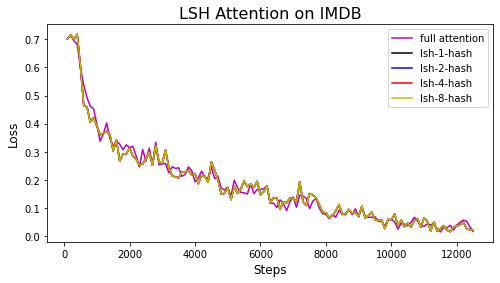

In [31]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(full_attention_steps, full_attention_loss, c="m", label="full attention")
ax.plot(lsh_1_steps, lsh_1_loss, c="k", label="lsh-1-hash")
ax.plot(lsh_2_steps, lsh_2_loss, c="b", label="lsh-2-hash")
ax.plot(lsh_4_steps, lsh_4_loss, c="r", label="lsh-4-hash")
ax.plot(lsh_8_steps, lsh_8_loss, c="y", label="lsh-8-hash")
ax.legend()
ax.set_xlabel("Steps", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.set_title("LSH Attention on IMDB", fontsize=16)
plt.show()